In [2]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# Attempt to import the 'ta' library for technical indicators
try:
    import ta
    ta_available = True
except ImportError:
    ta_available = False
    print("Technical Analysis library 'ta' not found. ADX will be skipped. RSI and Momentum will be calculated manually.")

Technical Analysis library 'ta' not found. ADX will be skipped. RSI and Momentum will be calculated manually.


In [3]:
df=pd.read_csv("10-ticker-data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Ticker', 'Date'])


In [4]:
# Define Tech Stocks (as per common understanding, user mentioned "tech already selected")
tech_tickers = ['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'NVDA', 'INTC', 'PLTR']
df_tech = df[df['Ticker'].isin(tech_tickers)].copy() # Use .copy() to avoid SettingWithCopyWarning

# --- Insight: Data Duration ---
# The dataset spans from 2025-05-14 to 2025-06-13, which is approximately one month (22 trading days).
# This is a very short period for deriving robust insights from technical indicators and clustering.
# Many indicators require longer look-back periods (e.g., 14 days), which will significantly reduce
# the number of data points available for analysis after accounting for the look-back window.
# The results should be interpreted as illustrative given this data limitation.
print(f"Data loaded. Number of trading days: {df['Date'].nunique()}")
print(f"Selected tech tickers: {tech_tickers}")


Data loaded. Number of trading days: 22
Selected tech tickers: ['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'NVDA', 'INTC', 'PLTR']


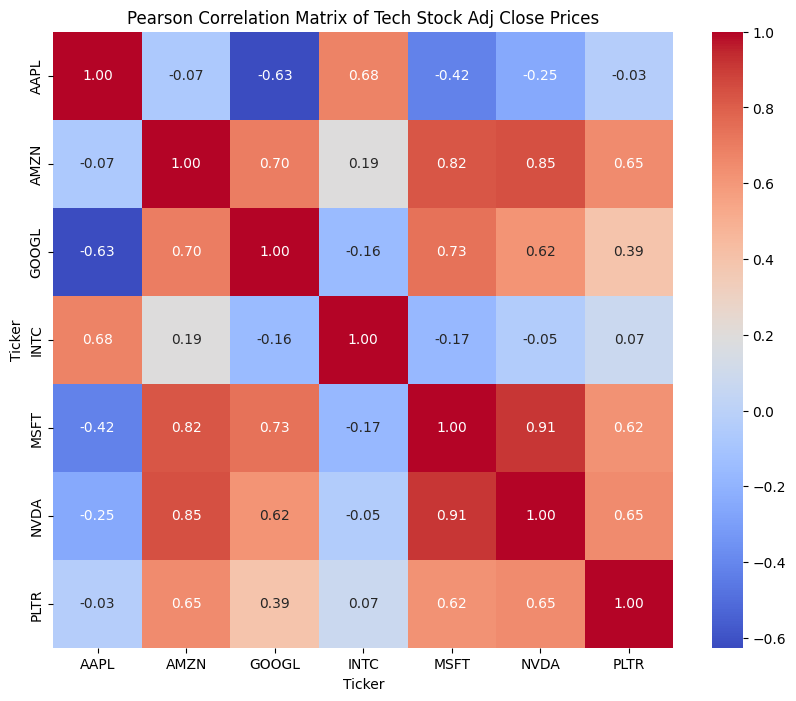

Correlation between AAPL and MSFT: -0.42
Correlation between GOOGL and AMZN: 0.70


In [5]:
# --- 1. Correlation Analysis (Tech Sector) ---
# Pivot table for 'Adj Close' prices of tech stocks
adj_close_pivot = df_tech.pivot_table(index='Date', columns='Ticker', values='Adj Close')

# Pearson Correlation of Adjusted Close prices
tech_corr = adj_close_pivot.corr(method='pearson')

# Visualization: Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(tech_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Pearson Correlation Matrix of Tech Stock Adj Close Prices')
plt.show()

# --- Insight: Tech Stock Correlations & Outliers ---
# The heatmap shows the Pearson correlation coefficients between the selected tech stocks.
# Values close to +1 indicate strong positive correlation (stocks tend to move in the same direction).
# Values close to -1 indicate strong negative correlation.
# Values close to 0 indicate weak or no linear correlation.
# For example, we can examine specific pairs:
if 'AAPL' in tech_corr and 'MSFT' in tech_corr:
    print(f"Correlation between AAPL and MSFT: {tech_corr.loc['AAPL', 'MSFT']:.2f}")
if 'GOOGL' in tech_corr and 'AMZN' in tech_corr:
    print(f"Correlation between GOOGL and AMZN: {tech_corr.loc['GOOGL', 'AMZN']:.2f}")

# Outlier detection based on correlation:
# Stocks that have consistently low correlations with the rest of the group might be considered
# "outliers" in terms of price co-movement. For instance, INTC and PLTR show lower correlations
# with some of the other large-cap tech stocks in this short period.
# However, with such a short timeframe, these observations are tentative.


In [6]:
# --- 2. Feature Engineering: Log Values & Technical Indicators ---
# We will calculate Log Close, RSI, Volatility, Momentum, and ADX (if 'ta' is available).
# Due to the short dataset, we'll use shorter windows for indicators than standard.
# RSI_WINDOW = 7
# VOLATILITY_WINDOW = 5  (on log returns, so effectively 6 days of price data)
# MOMENTUM_WINDOW = 3
# ADX_WINDOW = 7

# Functions for manual calculation if 'ta' is not available
def manual_rsi(close_prices, window=7):
    delta = close_prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def manual_momentum(close_prices, window=3):
    momentum = (close_prices / close_prices.shift(window)) - 1
    return momentum * 100 # As percentage

# Group by Ticker to apply calculations
df_tech_features = df_tech.groupby('Ticker').apply(lambda x: x.assign(
    Log_Adj_Close = np.log(x['Adj Close']),
    Log_Return = np.log(x['Adj Close'] / x['Adj Close'].shift(1)),
    RSI = ta.momentum.RSIIndicator(x['Adj Close'], window=7).rsi() if ta_available else manual_rsi(x['Adj Close'], window=7),
    Momentum = ta.momentum.ROCIndicator(x['Adj Close'], window=3).roc() if ta_available else manual_momentum(x['Adj Close'], window=3)
)).reset_index(drop=True) # Important to reset index after groupby.apply for future merges

# Volatility (Rolling Std Dev of Log Returns)
df_tech_features = df_tech_features.groupby('Ticker').apply(
    lambda x: x.assign(Volatility = x['Log_Return'].rolling(window=5).std())
).reset_index(drop=True)


if ta_available:
    df_tech_features = df_tech_features.groupby('Ticker').apply(lambda x: x.assign(
        ADX = ta.trend.ADXIndicator(x['High'], x['Low'], x['Close'], window=7).adx()
    )).reset_index(drop=True)
else:
    df_tech_features['ADX'] = np.nan # ADX skipped

# --- Insight: Feature Engineering ---
# New columns added: Log_Adj_Close, RSI, Volatility, Momentum, ADX (if available).
# Log_Adj_Close helps stabilize variance.
# RSI measures speed and change of price movements (momentum oscillator).
# Volatility measures price dispersion.
# Momentum measures the rate of price change.
# ADX measures trend strength (non-directional).
# These features will have NaNs at the beginning due to look-back windows.
print("\nSample of DataFrame with new features (first few rows for AAPL):")
print(df_tech_features[df_tech_features['Ticker'] == 'AAPL'].head(10))
print("\nNaN counts per new feature:")
print(df_tech_features[['Log_Adj_Close', 'RSI', 'Volatility', 'Momentum', 'ADX']].isnull().sum())




Sample of DataFrame with new features (first few rows for AAPL):
        Date Ticker        Open        High         Low       Close  \
0 2025-05-14   AAPL  212.429993  213.940002  210.580002  212.330002   
1 2025-05-15   AAPL  210.949997  212.960007  209.539993  211.449997   
2 2025-05-16   AAPL  212.360001  212.570007  209.770004  211.259995   
3 2025-05-19   AAPL  207.910004  209.479996  204.259995  208.779999   
4 2025-05-20   AAPL  207.669998  208.470001  205.029999  206.860001   
5 2025-05-21   AAPL  205.169998  207.039993  200.710007  202.089996   
6 2025-05-22   AAPL  200.710007  202.750000  199.699997  201.360001   
7 2025-05-23   AAPL  193.669998  197.699997  193.460007  195.270004   
8 2025-05-27   AAPL  198.300003  200.740005  197.429993  200.210007   
9 2025-05-28   AAPL  200.589996  202.729996  199.899994  200.419998   

    Adj Close    Volume  Log_Adj_Close  Log_Return        RSI  Momentum  \
0  212.330002  49325800       5.358142         NaN        NaN       NaN   
1 

/var/folders/s4/ltdhgr6d5nlgnqb60vkcr5700000gn/T/ipykernel_3232/2165162393.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_tech_features = df_tech.groupby('Ticker').apply(lambda x: x.assign(
/var/folders/s4/ltdhgr6d5nlgnqb60vkcr5700000gn/T/ipykernel_3232/2165162393.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_tech_features = df_tech_features.groupby('Ticker').apply(


In [7]:
file_name="10-ticker-stock-ti.csv"
df_tech_features.to_csv(file_name)


Number of data points available for clustering after NaN removal: 112


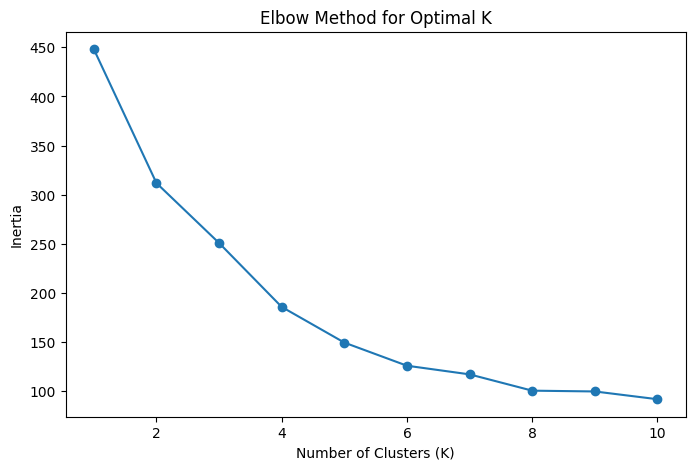

Based on Elbow method (visual inspection) or default, choosing K=3

Cluster Characteristics (Mean Feature Values):
         Log_Adj_Close        RSI  Volatility  Momentum
Cluster                                                
0             5.167815  35.063440    0.014895 -1.147079
1             5.328537  70.470593    0.016776  2.287491
2             3.220909  37.531207    0.028922 -1.802573


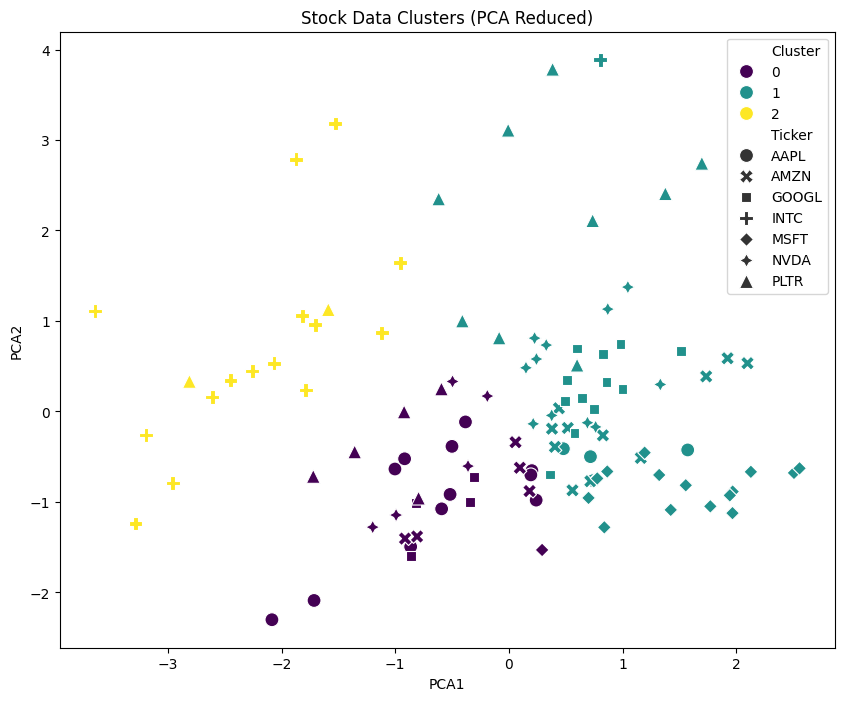

In [8]:
# --- 3. Clustering ---
# Prepare data for clustering
# Select features: Log_Adj_Close (standardized), RSI, Volatility, Momentum, ADX
features_for_clustering = ['Log_Adj_Close', 'RSI', 'Volatility', 'Momentum']
if ta_available and 'ADX' in df_tech_features.columns:
    features_for_clustering.append('ADX')
else: # If ADX was not calculated, ensure it's not in the list
    if 'ADX' in features_for_clustering:
        features_for_clustering.remove('ADX')


df_cluster_input = df_tech_features.dropna(subset=features_for_clustering).copy()

# --- Insight: Data for Clustering ---
# After removing NaNs from feature calculation, the number of data points for clustering is reduced.
# If this number is very small, clustering results might not be stable or meaningful.
print(f"\nNumber of data points available for clustering after NaN removal: {len(df_cluster_input)}")

if len(df_cluster_input) < len(tech_tickers) * 5: # Arbitrary threshold for meaningful clustering
    print("Warning: Very few data points available for clustering. Results may not be meaningful.")
    # Proceeding for demonstration, but this is a critical limitation.

if len(df_cluster_input) > 1 and len(features_for_clustering) > 0 : # Check if there's data to cluster
    # Standardize the features
    scaler = StandardScaler()
    df_cluster_input_scaled = scaler.fit_transform(df_cluster_input[features_for_clustering])
    df_cluster_input_scaled = pd.DataFrame(df_cluster_input_scaled, columns=features_for_clustering, index=df_cluster_input.index)

    # Determine optimal K for K-Means (Elbow Method)
    inertia = []
    # Max clusters to test: min(10, num_samples -1)
    # Ensure K is less than number of samples
    max_k_to_test = min(10, len(df_cluster_input_scaled) -1) if len(df_cluster_input_scaled) >1 else 1


    if max_k_to_test > 1: # only if we can test more than 1 cluster
        for k_val in range(1, max_k_to_test + 1):
            kmeans_elbow = KMeans(n_clusters=k_val, random_state=42, n_init='auto')
            kmeans_elbow.fit(df_cluster_input_scaled)
            inertia.append(kmeans_elbow.inertia_)

        plt.figure(figsize=(8, 5))
        plt.plot(range(1, max_k_to_test + 1), inertia, marker='o')
        plt.title('Elbow Method for Optimal K')
        plt.xlabel('Number of Clusters (K)')
        plt.ylabel('Inertia')
        plt.show()
        # --- Insight: Optimal K ---
        # The "elbow" in the plot suggests an optimal K. For this very short dataset,
        # it's likely to be a small number (e.g., 2 or 3).
        # Let's pick K=3 for demonstration if the plot is not clear or too few points.
        chosen_k = 3 if max_k_to_test >=3 else max_k_to_test # Default to 3 or max possible if less than 3
        print(f"Based on Elbow method (visual inspection) or default, choosing K={chosen_k}")


        # Perform K-Means Clustering
        kmeans = KMeans(n_clusters=chosen_k, random_state=42, n_init='auto')
        df_cluster_input['Cluster'] = kmeans.fit_predict(df_cluster_input_scaled)

        # --- Insight: Cluster Analysis ---
        # Analyze cluster characteristics by looking at the mean of features per cluster.
        cluster_summary = df_cluster_input.groupby('Cluster')[features_for_clustering].mean()
        print("\nCluster Characteristics (Mean Feature Values):")
        print(cluster_summary)

        # Visualization: PCA for Cluster Visualization (if >1 feature)
        if df_cluster_input_scaled.shape[1] > 1:
            pca = PCA(n_components=2, random_state=42)
            df_pca = pca.fit_transform(df_cluster_input_scaled)
            df_pca = pd.DataFrame(data=df_pca, columns=['PCA1', 'PCA2'], index=df_cluster_input.index)
            df_pca['Cluster'] = df_cluster_input['Cluster']
            df_pca['Ticker'] = df_cluster_input['Ticker'] # For labeling points

            plt.figure(figsize=(10, 8))
            sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', style='Ticker', data=df_pca, palette='viridis', s=100)
            plt.title('Stock Data Clusters (PCA Reduced)')
            plt.show()
        else:
            print("\nPCA visualization skipped as there is only 1 feature for clustering.")
